## Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mtick
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
# some matplotlib params to make the defaults a bit more readable
mpl.rcParams['figure.figsize'] = [8.0, 6.0]
mpl.rcParams['font.size'] = 15
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

## Load data

In [3]:
hdb = pd.read_csv('./data/hdb_full.csv')
display(hdb.info())
hdb.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174397 entries, 0 to 174396
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   town              174397 non-null  object 
 1   floor_area_sqm    174397 non-null  float64
 2   flat_model        174397 non-null  object 
 3   resale_price_adj  174397 non-null  float64
 4   year              174397 non-null  int64  
 5   mth               174397 non-null  int64  
 6   f_type            174397 non-null  int64  
 7   avg_storey        174397 non-null  int64  
 8   remaining_lease   174397 non-null  int64  
 9   address           174397 non-null  object 
 10  nearest_mrt       174397 non-null  object 
 11  dist_to_mrt       174397 non-null  float64
 12  nearest_top20     174397 non-null  object 
 13  is_<2km_top20     174397 non-null  int64  
 14  time_to_city      174397 non-null  float64
 15  nearest_mall      174397 non-null  object 
 16  dist_to_mall      17

None

,town,floor_area_sqm,flat_model,resale_price_adj,year,mth,f_type,avg_storey,remaining_lease,address,nearest_mrt,dist_to_mrt,nearest_top20,is_<2km_top20,time_to_city,nearest_mall,dist_to_mall,dist_to_city
13828,JURONG WEST,133.000,Apartment,518889.395,2012,5,5,8,89,656A JURONG WEST ST 61,Pioneer,0.331,RULANG PRIMARY SCHOOL,0,50.300,Pioneer Mall,0.742,17.865
118615,YISHUN,104.000,Model A,378176.865,2012,8,3,5,72,131 YISHUN ST 11,Yishun,0.538,CHIJ ST. NICHOLAS GIRLS' SCHOOL,0,53.417,Northpoint City,0.741,16.641
142513,TAMPINES,121.000,Improved,419552.048,2016,8,4,2,72,489C TAMPINES ST 45,Tampines East,0.617,GONGSHANG PRIMARY SCHOOL,1,51.050,White Sands,0.642,14.508
104805,TOA PAYOH,68.000,Improved,290241.233,2017,5,2,8,52,100 LOR 1 TOA PAYOH,Braddell,0.198,PEI CHUN PUBLIC SCHOOL,1,30.817,HDB Hub,0.831,6.153
72548,YISHUN,67.000,New Generation,276969.949,2014,9,2,2,70,204 YISHUN ST 21,Yishun,0.143,CHIJ ST. NICHOLAS GIRLS' SCHOOL,0,45.417,Northpoint City,0.289,16.317


## Dummy coding
Although statsmodel is able to handle categorical variables in multilinear regression models through the use of R-style formulas, we're going to dummy our categorical variables anyway because we want to calculate the Variance Inflation Factor later.

In [4]:
# for convenience later, we want to lowercase our names as they will become our column names
# and also replace spaces with _
hdb['town'] = hdb['town'].str.lower().str.replace(' ','_')
hdb['flat_model'] = hdb['flat_model'].str.lower().str.replace(' ','_')

In [5]:
# create a new df with the dummied vars
hdb_dummy = pd.get_dummies(data=hdb, columns=['town', 'flat_model'], drop_first=True, prefix=['town', 'model'])

In [95]:
hdb_dummy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174397 entries, 0 to 174396
Data columns (total 60 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   floor_area_sqm                174397 non-null  float64
 1   resale_price_adj              174397 non-null  float64
 2   year                          174397 non-null  int64  
 3   mth                           174397 non-null  int64  
 4   f_type                        174397 non-null  int64  
 5   avg_storey                    174397 non-null  int64  
 6   remaining_lease               174397 non-null  int64  
 7   address                       174397 non-null  object 
 8   nearest_mrt                   174397 non-null  object 
 9   dist_to_mrt                   174397 non-null  float64
 10  nearest_top20                 174397 non-null  object 
 11  is_<2km_top20                 174397 non-null  int64  
 12  time_to_city                  174397 non-nul

In dummying these variables, we have to drop 1 column to act as the reference column for that variable. So for town, the reference category is Ang Mo Kio, and for flat model, the reference category is 2-room.

## Multilinear Regression
We'll be performing multinear regression on our dummied dataset. The statsmodels' OLS class helps us to calculate the coefficients and p-value for each variable, and also calculates the R2 and adjusted R2 for our model, which is a measure of goodness of fit of the line of regression on the original dataset. 

In [6]:
# if we want to use patsy formula, we can't use <2km in our column name
hdb_dummy.rename(columns=({'is_<2km_top20':'is_near_top20'}), inplace=True)

In [435]:
# set our target variable resale_price_adj as y and our predictors as X
y = hdb_dummy['resale_price_adj']
X = hdb_dummy.drop(columns=(['address','nearest_mrt','nearest_mall','nearest_top20','f_type','dist_to_city','mth',
                             'resale_price_adj']))
# for sm.OLS, we need to manually add the constant
X = sm.add_constant(X, prepend=True)

In [117]:
X.columns

Index(['const', 'floor_area_sqm', 'year', 'avg_storey', 'remaining_lease',
       'dist_to_mrt', 'is_near_top20', 'time_to_city', 'dist_to_mall',
       'town_bedok', 'town_bishan', 'town_bukit_batok', 'town_bukit_merah',
       'town_bukit_panjang', 'town_bukit_timah', 'town_central_area',
       'town_choa_chu_kang', 'town_clementi', 'town_geylang', 'town_hougang',
       'town_jurong_east', 'town_jurong_west', 'town_kallang/whampoa',
       'town_marine_parade', 'town_pasir_ris', 'town_punggol',
       'town_queenstown', 'town_sembawang', 'town_sengkang', 'town_serangoon',
       'town_tampines', 'town_toa_payoh', 'town_woodlands', 'town_yishun',
       'model_adjoined_flat', 'model_apartment', 'model_dbss',
       'model_improved', 'model_improved-maisonette', 'model_maisonette',
       'model_model_a', 'model_model_a-maisonette', 'model_model_a2',
       'model_multi_generation', 'model_new_generation',
       'model_premium_apartment', 'model_premium_apartment_loft',
       'mode

### Identifying multicollinearity through the Variance Inflation Factor
One problem with running models with as many variables as we have is that multicollinearity becomes more likely. One way to check how multicollinear our variables are is to use a heatmap like before, which shows how correlated each of our variables are with each other. However, after dummying our categorical variables, we now have over 50 variables, which makes it hard to use a heatmap. So we will calculate the VIF for each variable. The higher the VIF, the more multicollinear a particular variable is with the other predictor variables.

VIF is calculated by essentially regressing each predictor variable on the other predictor variables. The less that the other predictor variables are able to explain each predictor variable, the less multicollinear that variable is with the others.

In [292]:
# calculate VIF for each variable
vif = {X.columns[i]:variance_inflation_factor(X.values, i) for i in range(X.shape[1])}
# load VIFs into df to inspect by magnitude.
pd.DataFrame.from_dict(vif, orient='index').sort_values(by=0, ascending=False)

,0
const,686980.927
model_model_a,9265.982
model_improved,8292.174
model_new_generation,5804.887
model_premium_apartment,3899.520
model_simplified,2022.724
model_apartment,1688.918
model_standard,1381.649
model_maisonette,1222.380
model_model_a2,605.930


Many of our flat models have high VIF, indicating that much of their variance can be explained by other predictor variables. However, this is to be expected. Consider a categorical variable with 3 categories, A B and C. We know that our data must belong to one of these 3 categories. If we know for one observation that it is NOT in A, it must be in B or C. With this information that A=0 for that observation, B and C become more likely. Hence for categorical variables, the categories within each variable will always be somehwat multicollinear.

We see that among our numerical variables, time_to_city is the only one with noticeably higher VIF than the rest. I will remove time_to_city and recalculate the VIFs.

In [8]:
X = hdb_dummy.drop(columns=(['address','nearest_mrt','nearest_mall','nearest_top20','f_type','time_to_city','mth',
                             'resale_price_adj', 'dist_to_city'])).copy()
X = sm.add_constant(X, prepend=True)
vif = {X.columns[i]:variance_inflation_factor(X.values, i) for i in range(X.shape[1])}
pd.DataFrame.from_dict(vif, orient='index').sort_values(by=0, ascending=False)

,0
const,686954.651
model_model_a,9265.458
model_improved,8291.713
model_new_generation,5804.580
model_premium_apartment,3899.347
model_simplified,2022.615
model_apartment,1688.823
model_standard,1381.585
model_maisonette,1222.305
model_model_a2,605.894


The remaining variables with high VIFs all belong to the flat model variable and none others, indicating that the multicollinearity present exists only within the different levels of flat model. Thus, we can be assured that multicollinearity for our remaining variables is low to moderate at most.

### MLR
We are going to run MLR on the full dataset. As a reminder, these are our predictor variables:

    1) floor_area_sqm
    2) year
    3) avg_storey
    4) remaining_lease
    5) dist_to_mrt
    6) is_near_top20
    7) dist_to_mall
    8) town (dummied)
    9) flat model (dummied)
    
First we will run without any transformations to the target or predictor variables.

In [490]:
model2 = sm.OLS(y, X)
res2 = model2.fit()

In [491]:
res2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       resale_price_adj   R-squared:                       0.861
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                 2.117e+04
Date:                Sat, 19 Jun 2021   Prob (F-statistic):               0.00
Time:                        23:57:13   Log-Likelihood:            -2.1361e+06
No. Observations:              174397   AIC:                         4.272e+06
Df Residuals:                  174345   BIC:                         4.273e+06
Df Model:                          51                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                        -1.064e+07      1e+05   -106.150      0.000   -1.08e+07   -1.04e+07
floor_area_sqm                3706.7859      7.335    505.380      0.000    3692.410    3721.162
year                          5168.2542     47.938    107.811      0.000    5074.296    5262.212
avg_storey                    4108.0268     24.504    167.645      0.000    4059.999    4156.055
remaining_lease               4435.9848     16.925    262.093      0.000    4402.812    4469.158
dist_to_mrt                  -5.675e+04    399.307   -142.123      0.000   -5.75e+04    -5.6e+04
is_near_top20                 5975.4599    401.461     14.884      0.000    5188.605    6762.314
dist_to_mall                 -1.675e+04    381.860    -43.872      0.000   -1.75e+04    -1.6e+04
town_bedok                   -1.708e+04    787.326    -21.696      0.000   -1.86e+04   -1.55e+04
town_bishan                   7.512e+04   1093.567     68.689      0.000     7.3e+04    7.73e+04
town_bukit_batok             -7.258e+04    931.262    -77.942      0.000   -7.44e+04   -7.08e+04
town_bukit_merah               8.48e+04    883.864     95.946      0.000    8.31e+04    8.65e+04
town_bukit_panjang           -1.502e+05    998.091   -150.527      0.000   -1.52e+05   -1.48e+05
town_bukit_timah              1.532e+05   2567.700     59.662      0.000    1.48e+05    1.58e+05
town_central_area             5.764e+04   1746.703     33.000      0.000    5.42e+04    6.11e+04
town_choa_chu_kang            -1.72e+05    960.215   -179.128      0.000   -1.74e+05    -1.7e+05
town_clementi                 2.766e+04    967.929     28.578      0.000    2.58e+04    2.96e+04
town_geylang                  1.543e+04   1062.287     14.522      0.000    1.33e+04    1.75e+04
town_hougang                 -6.874e+04    833.397    -82.479      0.000   -7.04e+04   -6.71e+04
town_jurong_east             -4.214e+04   1028.256    -40.981      0.000   -4.42e+04   -4.01e+04
town_jurong_west             -1.151e+05    783.480   -146.914      0.000   -1.17e+05   -1.14e+05
town_kallang/whampoa          3.002e+04    976.477     30.744      0.000    2.81e+04    3.19e+04
town_marine_parade            1.986e+05   1701.499    116.692      0.000    1.95e+05    2.02e+05
town_pasir_ris               -8.573e+04    969.607    -88.421      0.000   -8.76e+04   -8.38e+04
town_punggol                 -1.413e+05   1006.978   -140.316      0.000   -1.43e+05   -1.39e+05
town_queenstown               8.161e+04   1009.446     80.851      0.000    7.96e+04    8.36e+04
town_sembawang                -1.66e+05   1110.742   -149.416      0.000   -1.68e+05   -1.64e+05
town_sengkang                 -1.52e+05    917.758   -165.633      0.000   -1.54e+05    -1.5e+05
town_serangoon                1.243e+04   1050.124     11.838      0.000    

In [493]:
preds = res2.predict(X)
resids = preds - y

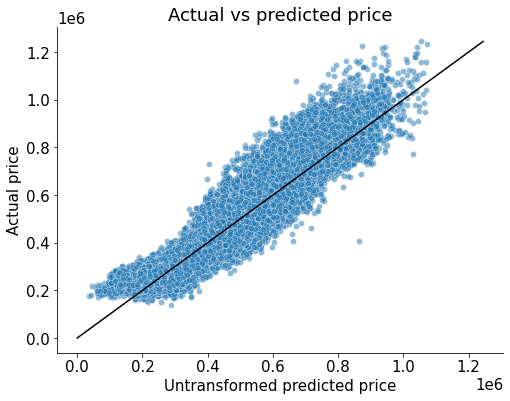

In [403]:
sns.scatterplot(x=preds, y=y, alpha=0.5)
sns.lineplot(x=[0,np.max(y)],y=[0,np.max(y)], color='black')
plt.xlabel('Untransformed predicted price'), plt.ylabel('Actual price')
plt.title('Actual vs predicted price');

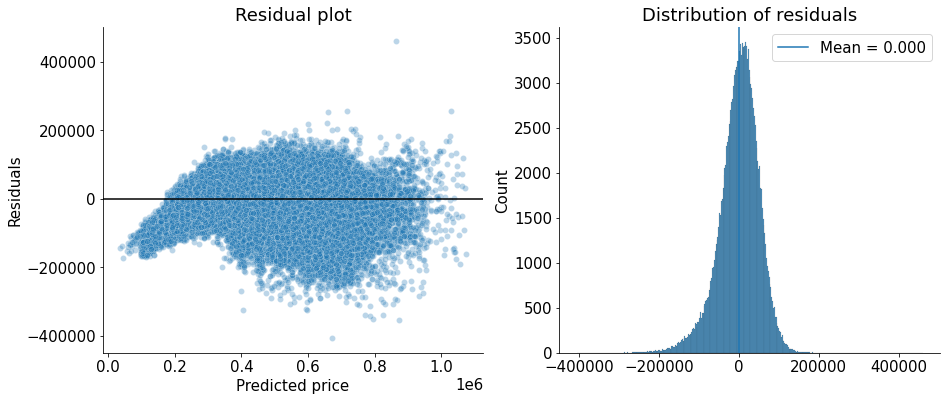

In [404]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,6))
g = sns.scatterplot(x=preds, y=resids, alpha=0.3, ax=ax1)
g.axhline(0, color='black')
g.set_xlabel('Predicted price'), g.set_ylabel('Residuals')
g.set_title('Residual plot')
h = sns.histplot(resids, ax=ax2)
h.axvline(resids.mean(),label='Mean = {:.3f}'.format(resids.mean()))
h.legend()
h.set_title('Distribution of residuals');

In [494]:
from sklearn.metrics import mean_squared_error
print('RMSE of model: {:3f}'.format(mean_squared_error(y, (preds), squared=False)))

RMSE of model: 50500.229420


Some observations above:

1. Our OLS summary tells us that a high condition number indicates possible multicollinearity. This is likely due to the dummied variables, which we explored earlier through the VIF.
2. Some categories within flat model are statistically non-significant.
3. There is some non-linearity present still in our predictions. Our plot of predicted vs actual price shows signs of being 'banana' shaped.
4. Our residual plot displays severe heteroskedasticity. The distribution of our residuals is also slightly left skewed.

To fix this heteroskedasticity and non-linearity, we will apply a log transformation on our target variable. Log transformations are especially helpful in dealing with distributions with high outlier values, and in some cases, can help with non-significant predictors.

### MLR with log of y
Before re-running the model, I will be de-meaning the numerical variables. This is because interpreting regression coefficients in context of a target variable in log space changes slightly, and it will be clear later why de-meaning the numerical variables becomes useful.

In [495]:
# select cols to de-mean
num_cols = ['floor_area_sqm', 'year','avg_storey','remaining_lease','dist_to_mrt','dist_to_mall']
# de-mean the cols and save the means for reference later
var_means = {}
for col in num_cols:
    col_mean = X[col].mean()
    X[col] = X[col] - col_mean
    var_means[col] = col_mean

In [496]:
# we transform y into log space and rerun the model.
y_log = np.log(y)
model3 = sm.OLS(y_log, X)
res3 = model3.fit()

In [497]:
preds = res3.predict(X)
resids = y_log - preds

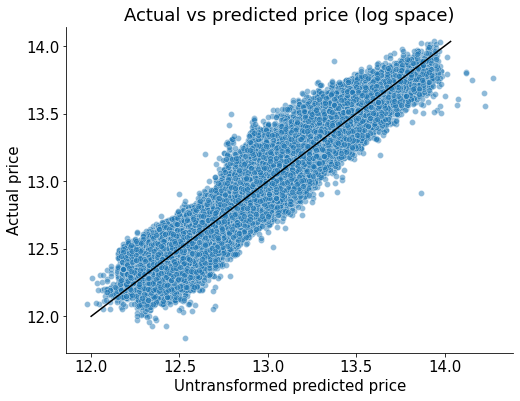

In [498]:
sns.scatterplot(x=preds, y=y_log, alpha=0.5)
plt.plot([12,np.max(y_log)],[12,np.max(y_log)], color='black')
plt.xlabel('Untransformed predicted price'), plt.ylabel('Actual price')
plt.title('Actual vs predicted price (log space)');

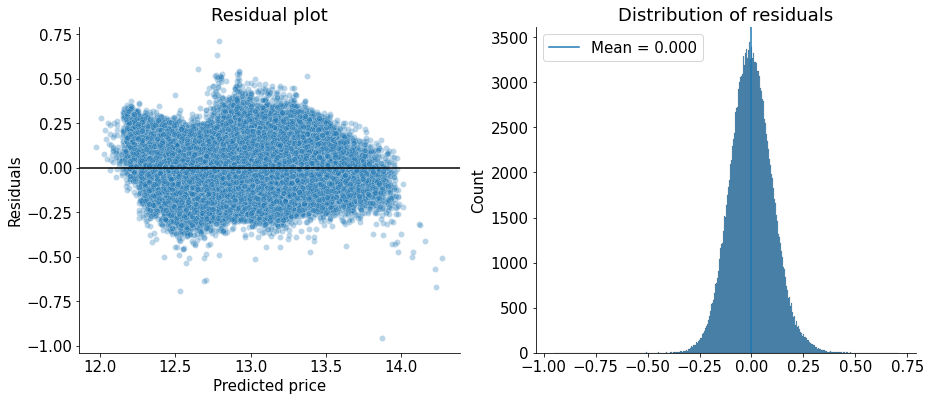

In [430]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,6))
g = sns.scatterplot(x=preds, y=resids, alpha=0.3, ax=ax1)
g.axhline(0, color='black')
g.set_xlabel('Predicted price'), g.set_ylabel('Residuals')
g.set_title('Residual plot')
h = sns.histplot(resids, ax=ax2)
h.axvline(resids.mean(),label='Mean = {:.3f}'.format(resids.mean()))
h.legend()
h.set_title('Distribution of residuals');

In [499]:
# exponentiate our preds to get them back in linear space to calculate RMSE
print('RMSE of model: {:3f}'.format(mean_squared_error(y, np.exp(preds), squared=False)))

RMSE of model: 47492.103280


Observations:

1. After applying log transformation on our target variable, our predictions cluster a lot more evenly around our actual prices.
2. Our residuals are much more homoskedastic now, although we see some outliers. We will examine these outliers later. The residuals distribution is also noticeably more normal now.
3. After transforming our predictions back into linear space, our RMSE has decreased from 50k to 47k, a slight improvement.

## Interpretation of results

First we look at the statsmodel OLS summary.

In [432]:
res3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       resale_price_adj   R-squared:                       0.882
Model:                            OLS   Adj. R-squared:                  0.881
Method:                 Least Squares   F-statistic:                 2.543e+04
Date:                Sat, 19 Jun 2021   Prob (F-statistic):               0.00
Time:                        02:41:02   Log-Likelihood:             1.4781e+05
No. Observations:              174397   AIC:                        -2.955e+05
Df Residuals:                  174345   BIC:                        -2.950e+05
Df Model:                          51                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                           12.8821      0.052    248.284      0.000      12.780      12.984
floor_area_sqm                   0.0093   1.51e-05    620.238      0.000       0.009       0.009
year                             0.0085   9.84e-05     86.156      0.000       0.008       0.009
avg_storey                       0.0081   5.03e-05    161.679      0.000       0.008       0.008
remaining_lease                  0.0100   3.47e-05    287.071      0.000       0.010       0.010
dist_to_mrt                     -0.1216      0.001   -148.295      0.000      -0.123      -0.120
is_near_top20                    0.0163      0.001     19.746      0.000       0.015       0.018
dist_to_mall                    -0.0437      0.001    -55.705      0.000      -0.045      -0.042
town_bedok                      -0.0276      0.002    -17.092      0.000      -0.031      -0.024
town_bishan                      0.1400      0.002     62.353      0.000       0.136       0.144
town_bukit_batok                -0.1609      0.002    -84.161      0.000      -0.165      -0.157
town_bukit_merah                 0.1753      0.002     96.581      0.000       0.172       0.179
town_bukit_panjang              -0.3146      0.002   -153.553      0.000      -0.319      -0.311
town_bukit_timah                 0.2784      0.005     52.818      0.000       0.268       0.289
town_central_area                0.1891      0.004     52.723      0.000       0.182       0.196
town_choa_chu_kang              -0.3704      0.002   -187.871      0.000      -0.374      -0.366
town_clementi                    0.0635      0.002     31.953      0.000       0.060       0.067
town_geylang                     0.0332      0.002     15.203      0.000       0.029       0.037
town_hougang                    -0.1411      0.002    -82.456      0.000      -0.144      -0.138
town_jurong_east                -0.0867      0.002    -41.078      0.000      -0.091      -0.083
town_jurong_west                -0.2456      0.002   -152.678      0.000      -0.249      -0.242
town_kallang/whampoa             0.0772      0.002     38.527      0.000       0.073       0.081
town_marine_parade               0.4642      0.003    132.876      0.000       0.457       0.471
town_pasir_ris                  -0.1714      0.002    -86.087      0.000      -0.175      -0.167
town_punggol                    -0.2753      0.002   -133.163      0.000      -0.279      -0.271
town_queenstown                  0.1752      0.002     84.522      0.000       0.171       0.179
town_sembawang                  -0.3391      0.002   -148.702      0.000      -0.344      -0.335
town_sengkang                   -0.3005      0.002   -159.489      0.000      -0.304      -0.297
town_serangoon                   0.0366      0.002     16.989      0.000    

Observations:

1. R2 and Adj R2
    - R2, or coefficient of determination, tells us how well our predictor variables can explain our target variable. It acts as a measure of goodness of fit.
    - The adjusted R2 penalizes the R2 when there are many predictor variables, which can lead to overfitting and thus over optimistic results. It is usually better to use the adjusted R2 score.
    - Our adjusted R2 is 0.881, so our predictor variables can explain our target variable quite well.
2. Prob (F-statistic)
    - This tells us the likelihood that none of our variables are significant. In this case, it is 0%.
3. Condition number and warning at bottom
    - This number *could* indicate multicollinearity. However, recall that we have already tested for that using the VIF, and that the multicollinearity is present within our flat model variable only, which is to be expected for a dummied variable.
4. p-values for each individual predictor
    - If a predictor has a p-value that is lower than the alpha value set, which is usually 0.05, we say that the predictor has a statistically significant effect. 
    - Majority of our predictors have p-value of 0.00, so they are very statistically significant.
    - The predictors that have p-value < 0.00 are all dummy variables. However, the highest p-value is only 0.035, meaning that the predictor is significant even at the 95% confidence level. 
5. Coefficients for each predictor
    - The coefficients tell us the effect that each predictor has on the target variable, given a 1 unit increase in the predictor.
    - Recall that our target variable is currently in log space, thus, a 1 unit increase in X1 will increase log(y) by the value of the coefficient.
    
To understand our coefficients better, we are going to exponentiate them, so that we can relate our coefficients to our target variable when it is in linear space.

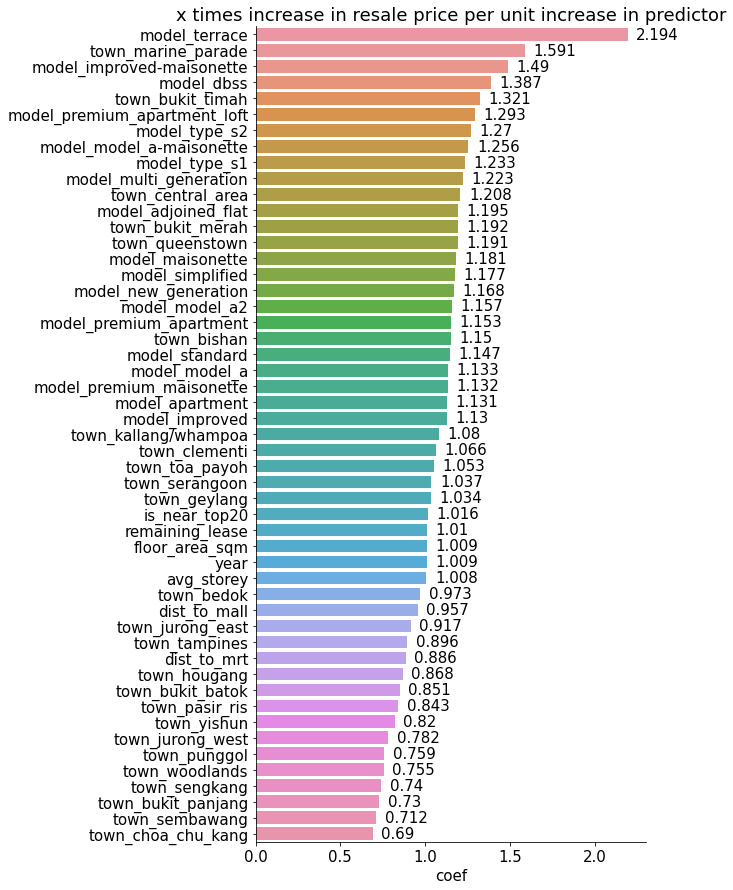

In [467]:
coefs = np.exp(res3.params).sort_values(ascending=False).drop(index='const')
coefs_df = pd.DataFrame(coefs, columns=['coef'])
fig, ax = plt.subplots(figsize=(7,15))
g = sns.barplot(y=coefs_df.index, x=coefs_df['coef'], ax=ax)
for n, x in enumerate(coefs):
    g.text(x + 0.05, n, str(round(x,3)), verticalalignment='center')
plt.title('x times increase in resale price per unit increase in predictor');

The model for this equation is rightly:
$$\log(y) = \beta_0 + \beta_1X_1 + \beta_2X_2 + \cdots + \beta_pX_p$$

So, to look at our target variable in linear space, we exponentiate both sides, giving:
$$y = e^{\beta_0 + \beta_1X_1 + \beta_2X_2 + \cdots + \beta_pX_p}$$

Because of log transformation of the target variable, the interpretation for coefficients has changed slightly. Now, for each unit in $X_i$, y will increase by $e^{\beta_i}$ times, where ${\beta_i}$ is the regression coefficient of $X_i$. By exponentiating each coefficient, we now know how much *times* our target variable will increase, for each unit increase in $X_i$.

For example, our model tells us that for a increase of 1 sqm in floor area, our resale price goes up by 0.9%. If a unit is near a top20 primary school, its resale price goes up by 1.6%. 
For our categorical variables, note that due to one-hot encoding, our reference for town is Ang Mo Kio, and our reference for flat_model is 2-room. Thus, a unit in Bukit Timah will cost 32.1% more than a unit in Ang Mo Kio, holding all other variables constant. A unit that is a premium_apartment_loft will cost 29.3% more than a 2-room unit, holding all other variables constant.

But what does holding other variables constant mean? There must be a base reference from which we can derive how much a 1% increase in price really is. The answer is that the reference house is a house where all predictor variables are 0. This is where our earlier de-meaning of our numerical variables comes in.

In [438]:
var_means

{'floor_area_sqm': 97.09725626014223,
 'year': 2016.20246907917,
 'avg_storey': 8.238811447444624,
 'remaining_lease': 74.93120294500478,
 'dist_to_mrt': 0.6645857154152895,
 'dist_to_mall': 0.6821143943356252}

What the above tells us is that this hypothetical reference unit is an Ang Mo Kio 2-Room flat of size 97.1 sq, on the 8th floor, with 75 remaining lease years, 0.66km from the nearest MRT, 0.68km from the nearest mall, is not near a top20 primary school, and bought in 2016. The resale price of this reference unit is \\$393203. This is because when all predictor variables are zero, the regression equation becomes 
$$y = e^{\beta_0}$$
Now when we say that the resale price increase by 1.6\% due to a house being near a top20 primary school, we know that it means it increases by 1.6\% of \\$393203.

In [440]:
# exponentiate our constant/intercept to get the reference resale price
np.exp(res3.params['const'])

393203.1930782736


Finally, let's plot our predictions back in linear space.

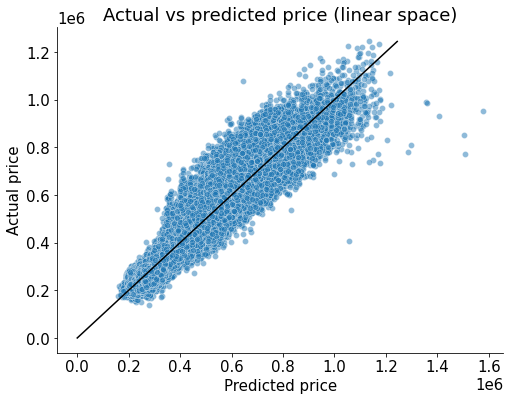

In [348]:
sns.scatterplot(x=np.exp(preds), y=y, alpha=0.5)
plt.plot([0,np.max(y)],[0,np.max(y)], color='black')
plt.xlabel('Predicted price'), plt.ylabel('Actual price')
plt.title('Actual vs predicted price (linear space)');

### Outliers
As we can see, for the most part our model does quite well. There are however, some predictions that are way off. For example, there are many outliers to the right of our diagonal line. These units are actually under \\$1mil, but our model predicted them to cost more than \\$1.2mil.

In [480]:
# looks at these outliers
temp = hdb[['town','address','floor_area_sqm','dist_to_mrt','time_to_city','year','flat_model','f_type',
            'avg_storey','remaining_lease','resale_price_adj']].copy()
temp['preds'] = np.exp(preds)
temp[temp['preds']>1200000]

,town,address,floor_area_sqm,dist_to_mrt,time_to_city,year,flat_model,f_type,avg_storey,remaining_lease,resale_price_adj,preds
30074,bishan,273B BISHAN ST 24,120.000,0.776,38.650,2017,dbss,4,41,93,1110253.853,1217119.960
30118,bishan,273B BISHAN ST 24,120.000,0.776,38.650,2016,dbss,4,41,94,978783.593,1218941.915
50078,bishan,443 SIN MING AVE,199.000,1.298,43.267,2013,maisonette,5,8,76,778521.411,1287096.356
50190,bishan,445 SIN MING AVE,190.000,1.345,43.283,2016,maisonette,5,11,73,828878.499,1203376.828
100457,kallang/whampoa,59 JLN MA'MOR,181.000,1.020,37.083,2017,terrace,2,2,54,770804.587,1509406.082
100461,kallang/whampoa,59 JLN MA'MOR,180.000,1.020,37.083,2013,terrace,2,2,58,852011.110,1504348.692
113351,kallang/whampoa,55 JLN BAHAGIA,170.000,1.040,36.283,2020,terrace,2,2,51,989080.551,1355733.977
134982,bishan,446 BRIGHT HILL DR,199.000,1.231,44.717,2016,maisonette,5,8,73,811015.391,1299113.191
157931,kallang/whampoa,44 JLN BAHAGIA,185.000,0.947,35.200,2018,terrace,2,2,53,951426.156,1578005.008
159617,kallang/whampoa,58 JLN MA'MOR,174.000,1.042,36.950,2018,terrace,2,2,53,933294.037,1407511.563


Let's examine these units in detail.

The first 2 units appear to be the same type of unit, and possibly on the same floor. According to this [Propertyguru listing](https://www.propertyguru.com.sg/listing/hdb-for-sale-273b-bishan-street-24-23555045), this block is only 40 storeys high, which means the avg_storey of 41, which corresponds to a range of 40-42, indicates that these units are top floor units. The listing is for a unit above floor 30, and it already goes for 1million. A price of 1.2million may not be unreasonable for a top-floor unit then.

The next 3 Bishan units are very large executive maisonettes, larger than what maisonettes usually are, which is around 160sqm. Let's take a look at other maisonettes in Bishan to see how they are normally priced.

In [500]:
temp[(temp['flat_model']=='maisonette')&(temp['town']=='bishan') & (temp['dist_to_mrt']>1)].tail(10)

,town,address,floor_area_sqm,dist_to_mrt,time_to_city,year,flat_model,f_type,avg_storey,remaining_lease,resale_price_adj,preds
159020,bishan,258 BISHAN ST 22,147.000,1.159,38.583,2018,maisonette,5,2,73,697514.491,753014.696
159021,bishan,258 BISHAN ST 22,148.000,1.159,38.583,2020,maisonette,5,2,71,720050.641,757809.924
161995,bishan,240 BISHAN ST 22,146.000,1.127,38.050,2018,maisonette,5,2,73,842843.763,756359.673
161996,bishan,240 BISHAN ST 22,156.000,1.127,38.050,2018,maisonette,5,2,73,958305.810,830403.663
161997,bishan,240 BISHAN ST 22,146.000,1.127,38.050,2016,maisonette,5,2,75,766555.734,758625.817
161998,bishan,240 BISHAN ST 22,156.000,1.127,38.050,2012,maisonette,5,3,79,732138.118,844732.817
165623,bishan,247 BISHAN ST 22,146.000,1.222,37.033,2019,maisonette,5,2,72,777345.919,743959.383
165624,bishan,247 BISHAN ST 22,147.000,1.222,37.033,2015,maisonette,5,2,76,746837.511,755446.687
174382,bishan,404 SIN MING AVE,148.000,1.595,40.333,2014,maisonette,5,2,71,668999.588,691038.917
174383,bishan,404 SIN MING AVE,149.000,1.595,40.333,2014,maisonette,5,2,71,740815.645,697523.100


Many of these maisonettes range between 140-160 sqm in floor area, yet we see that easily command 700-800k minimum. We can see that that the 190sqm maisonettes are considerably underpriced for their size then considering the other Bishan maisonettes. The overprediction in our model thus appears to be rightly due to the size of the unit.
***
Finally let's look at the many terraces in kallang/whampoa that our model seems to be performing poorly on.

In [485]:
temp[(temp['flat_model']=='terrace')&(temp['town']=='kallang/whampoa')]

,town,address,floor_area_sqm,dist_to_mrt,time_to_city,year,flat_model,f_type,avg_storey,remaining_lease,resale_price_adj,preds
60264,kallang/whampoa,53 JLN MA'MOR,111.000,1.066,35.183,2017,terrace,2,2,54,708375.836,784392.277
60265,kallang/whampoa,53 JLN MA'MOR,119.000,1.066,35.183,2019,terrace,2,2,52,817979.182,842718.967
60266,kallang/whampoa,53 JLN MA'MOR,108.000,1.066,35.183,2019,terrace,2,2,52,854804.609,760441.463
100457,kallang/whampoa,59 JLN MA'MOR,181.000,1.020,37.083,2017,terrace,2,2,54,770804.587,1509406.082
100458,kallang/whampoa,59 JLN MA'MOR,79.000,1.020,37.083,2019,terrace,2,2,52,725682.191,580477.987
...,...,...,...,...,...,...,...,...,...,...,...,...
173968,kallang/whampoa,49 JLN BAHAGIA,80.000,1.023,35.033,2016,terrace,2,2,55,701234.206,590623.292
173969,kallang/whampoa,49 JLN BAHAGIA,80.000,1.023,35.033,2012,terrace,2,3,59,634996.816,599020.144
173970,kallang/whampoa,49 JLN BAHAGIA,80.000,1.023,35.033,2013,terrace,2,2,58,642842.149,593279.647
174066,kallang/whampoa,57 JLN MA'MOR,92.000,1.070,36.367,2013,terrace,2,2,58,760622.799,658293.885


Once again, notice the typical price ranges for these terraces, and their typical sizes. They are on average between 80-100 sqm, and cost between 600k-800k. Our model performs reasonably well for these. But going back to our outliers, these terraces are well over 160 sqm, reaching up to 180sqm in size, almost double the size of most of these other kallang terraces. Yet they go for just under a \\$1mil, for the most expensive of these, and one of them even goes for $770k, well within the price range of a 100sqm terrace. Our model is once again not performing well for these uniquely oversized units somehow.
***
There is one annoying outlier sitting on its own down and to the right, where resale price was below 500k but prediction was above \\$1mil.

In [363]:
# find outlier
temp[(temp['preds']>1000000) & (temp['resale_price_adj']<500000)]

,town,address,floor_area_sqm,dist_to_mrt,time_to_city,is_near_top20,year,flat_model,f_type,avg_storey,remaining_lease,resale_price_adj,preds
39274,queenstown,18C HOLLAND DR,117.000,0.380,32.600,1,2016,improved,4,38,95,405469.118,1054864.182


In [366]:
# look at all other transactions at this outlier's address and size
temp[(temp['address']=='18C HOLLAND DR') & (temp['floor_area_sqm']==117)]

,town,address,floor_area_sqm,dist_to_mrt,time_to_city,is_near_top20,year,flat_model,f_type,avg_storey,remaining_lease,resale_price_adj,preds
39250,queenstown,18C HOLLAND DR,117.000,0.380,32.600,1,2017,improved,4,23,94,935880.207,932312.823
39252,queenstown,18C HOLLAND DR,117.000,0.380,32.600,1,2017,improved,4,38,94,915360.623,1053287.474
39254,queenstown,18C HOLLAND DR,117.000,0.380,32.600,1,2018,improved,4,38,93,1080656.253,1051713.123
39255,queenstown,18C HOLLAND DR,117.000,0.380,32.600,1,2018,improved,4,2,93,849131.122,784752.421
39256,queenstown,18C HOLLAND DR,117.000,0.380,32.600,1,2019,improved,4,5,92,976462.649,802934.447
39257,queenstown,18C HOLLAND DR,117.000,0.380,32.600,1,2019,improved,4,2,92,865034.701,783579.450
39258,queenstown,18C HOLLAND DR,117.000,0.380,32.600,1,2019,improved,4,38,92,1163322.529,1050141.125
39261,queenstown,18C HOLLAND DR,117.000,0.380,32.600,1,2020,improved,4,20,91,1145355.278,905765.397
39262,queenstown,18C HOLLAND DR,117.000,0.380,32.600,1,2020,improved,4,8,91,972713.619,821537.734
39263,queenstown,18C HOLLAND DR,117.000,0.380,32.600,1,2020,improved,4,14,91,1108792.726,862624.166


All other units at this address and size go for at least $770k, and go up to \\$1.1mil, thus our outlier is truly and well an outlier. Whoever bought this unit at \\$400k is a very lucky person.

## Conclusions

In this project, we took the HDB resale price data from data.gov.sg, and analyzed it to understand what factors drive price. In addition to features already present in the dataset, we engineered some more based on the distance away from an amenity. We discovered that certain variables were highly correlated with each other, like flat type with floor area, and time_to_city with town. The MLR model that gave us normally distributed and homoskedastic residuals utilised a log transformation on the target variable of resale price, which resulted in all predictor variables being statistically significant at the 95% confidence level*(caveat below in the limitations section). 

Once again, these predictors are :

1. floor area
2. remaining lease
3. year bought/sold
4. storey that unit is on
5. distance to nearest mrt
6. distance to nearest mall
7. whether unit is near a top20 primary school
8. town (dummied)
9. flat model (dummied)

As expected, resale price goes up as floor area, remaining lease, unit storey, and year bought/sold increase. Resale price also predictably decreases as proximity to nearby amenities decreases, although, being near to a top20 primary school only results in a 1.6% increase in price, which surprised me because I thought it would be more than that, given that parents generally take their child's education very seriously. This could, of course, be mitigated by the fact that there are also many other ways to gain priority admission to a school, namely whether or not the parents were alumni, or if the child has a sibling also in that same primary school. 

It could perhaps be more interesting to look at the effect town has on price.

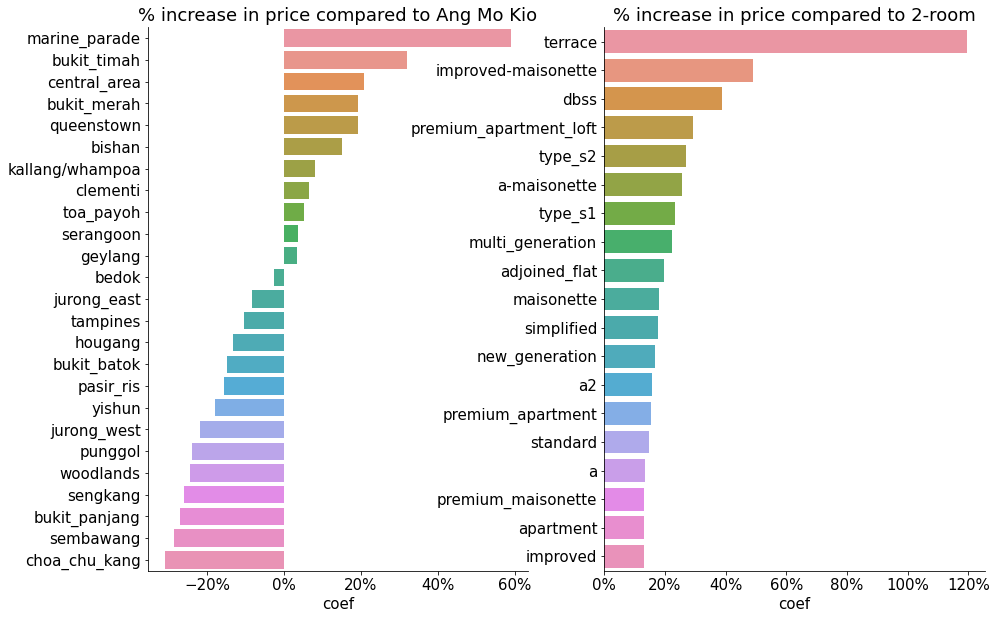

In [472]:
town_coefs = coefs_df[coefs_df.index.str.contains('town')]
town_coefs.index = town_coefs.index.str.replace('town_','')
model_coefs = coefs_df[coefs_df.index.str.contains('model')]
model_coefs.index = model_coefs.index.str.replace('model_','')
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,10))
g = sns.barplot(y=town_coefs.index, x=town_coefs['coef']-1, ax=ax1)
g.xaxis.set_major_formatter(mtick.PercentFormatter(1))
g.set_title('% increase in price compared to Ang Mo Kio')
h = sns.barplot(y=model_coefs.index, x=model_coefs['coef']-1, ax=ax2)
h.xaxis.set_major_formatter(mtick.PercentFormatter(1))
h.set_title('% increase in price compared to 2-room');

Interestingly, Marine Parade comes up to be the most expensive town, after controlling for all other variables. Neighborhoods like Bishan and Queenstown are also expensive, possibly due to their accessibility to town, and the fact that they are mature estates. On the other side of the spectrum, we see that the least expensive towns like Choa Chu Kang and Sembawang, all seem to be very far away from town. 

For model types, it seems that terraces are far and away the most expensive model. This is because terraces are no longer built, so these are super rare and hard to come by.

### Limitations

This actually brings us back to our earlier problem of multicollinearity between time_to_city and town. We can quite clearly see that without time_to_city, the town variable is the one that encodes that same information. Ideally, if we could separate the time component away from other characteristics of town, we could more accurately determine which towns are more expensive due to reasons not related to time taken to travel to the city, and we could also then include the time_to_city variable back into the model, without incurring multicollinearity between the 2 variables.

For flat_model, an inherent problem with it is that the categories within that variable do not inherently measure the same thing. Some measure size, some measure unique characteristics (like loft and terrace), some are simply a relic of old naming conventions (like standard, simplified, improved). It is not clear sometimes how categories are different from each other, for example with the various maisonette models, and as such, although the variable is technically significant in our model, it does not give us much useful information. 

Finally, a major limitation seen above in our model is in predicting resale prices for units with very large floor area. It appears that for whatever reason, there are many such jumbo sized units bigger than 180sqm that just aren't being transacted at a price representative of their size. More precisely, some of these units are being sold at similar or not much more expensive prices than other units in their area that are much smaller, as we have seen with the terraces for example.

### Recommendations

First, directly addressing the limitations would bring greater precision to our model. Likely, this will require recoding of the categories. For example, to separate time to city information from town, we could instead come up with variables like maturity of town, political stability, vibrancy of community etc. These could help to capture unique characteristics of each town that enable us to isolate why a particular town might be more attractive than others other than the distance/time to city factor. For flat models, I believe an overhaul is generally needed. Many of the models simply indicate that a flat is 'normal'. It really is only models like the maisonettes (2-storey units), terraces (unique ground floor units with backyards), and lofts (extra ceiling height) that provide new information about a unit. It might be better to recode flat model in terms of unique characteristics then, rather than what HDB decided to name each unit design that particular decade.

Other recommendations would be to explore engineering more features. This would require some domain knowledge definitely. Additionally, interaction terms is also something that could be explored exhaustively given more time.